In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

# Problem 1

## Part A

In [6]:
def get_antenna_pos(file, return_antpos=False):
    
    data = np.loadtxt(file)
    antpos = data[:, :3] * 1e-9 * 3e8
    
    latitude = 34.1 * np.pi / 180 # Want latitude in radians
    
    zenith = np.array([np.cos(latitude), 0, np.sin(latitude)])
    
    EW = np.array([0,1,0])
    NS = np.cross(zenith, EW)
            
    xyz = antpos@np.vstack([EW, NS, zenith]).T
    
    if return_antpos: 
        return xyz, antpos
    
    return xyz
    

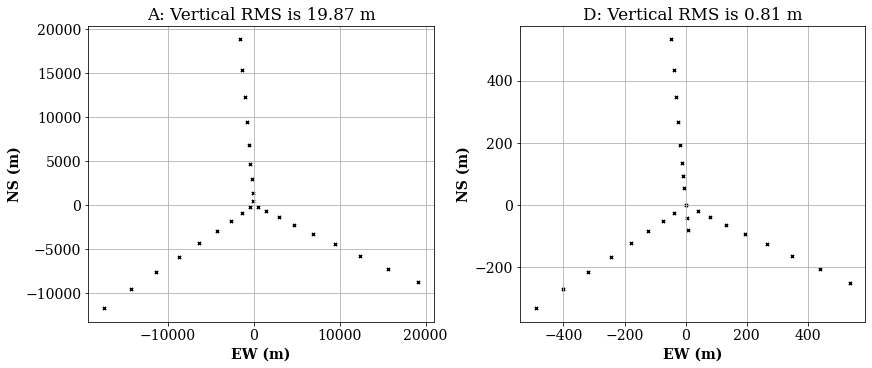

In [11]:
files = ['vla_a_array.txt', 'vla_d_array.txt']


titles = ['A', 'D']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5), constrained_layout=True)

for i, f in enumerate(files): 
    
    xyz = get_antenna_pos(f)
    
    # Extract EW and NS baselines
    EW = xyz[:,0]
    NS = xyz[:,1]
    
    
    vertical_rms = np.sqrt(np.mean(xyz[:,2]**2))
    
    axs[i].scatter(EW, NS, s = 10, marker='x', color='black')
    axs[i].set_title(titles[i] + ': Vertical RMS is {0} m'.format(round(vertical_rms,2)))
    axs[i].set_xlabel('EW (m)', fontweight='bold')
    axs[i].set_ylabel('NS (m)', fontweight='bold')
    axs[i].grid()
    
    
    
    
    
    
    
    

## Part B

In [8]:
def get_uv(file, dec_deg_arr, freq = 1.4e9, norm = 1000, return_all = False):
    
    xyz, antpos = get_antenna_pos(file, return_antpos = True)
    
    nant = xyz[:,0].shape[0]
    nvis = nant * (nant - 1) // 2
    uv = np.zeros([nvis,3])
    icur=0
    for i in range(nant):
        for j in range(i+1,nant):
            uv[icur,:]=antpos[i,:]-antpos[j,:]
            icur=icur+1
    uv=np.vstack([uv,-uv]) / 3e8 * freq / norm # will be in kilowavelengths by default


    # Declination to observe at 
    dec_arr = dec_deg_arr * np.pi / 180
    
    for d in dec_arr: 
        zenith = np.array([np.cos(d), 0, np.sin(d)])
        EW = np.array([0, 1, 0])
        NS = np.cross(zenith, EW)
        proj_mat = np.vstack([EW, NS])
        uv_snap=uv@proj_mat.T
        
    if return_all:
        return uv_snap, uv

    return uv_snap
    

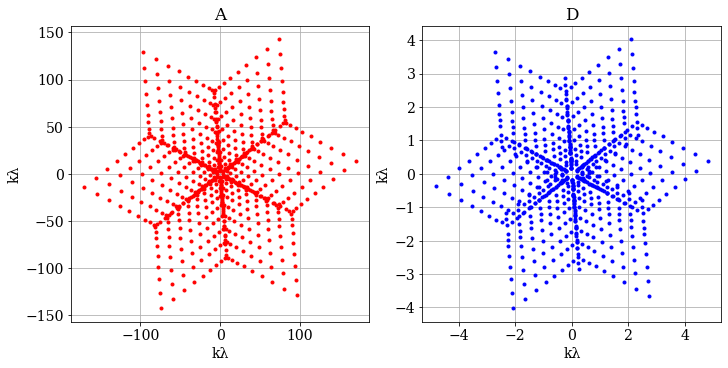

In [12]:
titles = ['A', 'D']
color = ['red', 'blue']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), constrained_layout=True)

for i, f in enumerate(files): 
    
    uv_snap = get_uv(f, np.array([31.5]))
    axs[i].plot(uv_snap[:,0],uv_snap[:,1], '.', color=color[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('kλ')
    axs[i].set_ylabel('kλ')
    axs[i].grid() 
    

## Part C

In [15]:
def get_beam(file, du, dec_deg_arr, freq = 1.4e9):
    
    uv_snap, uv = get_uv(file, dec_deg_arr, freq, norm=10, return_all=True)
    
    pad = 4
    sz = int(np.max(np.abs(uv))/du)
    uv_mat = np.zeros([pad*2*sz, pad*2*sz])
    uv_int=np.asarray(uv_snap/du,dtype='int')

    for i in range(uv_snap.shape[0]):
        uv_mat[uv_int[i,0],uv_int[i,1]]=uv_mat[uv_int[i,0],uv_int[i,1]]+1

    return np.abs(np.fft.ifft2(uv_mat))
    

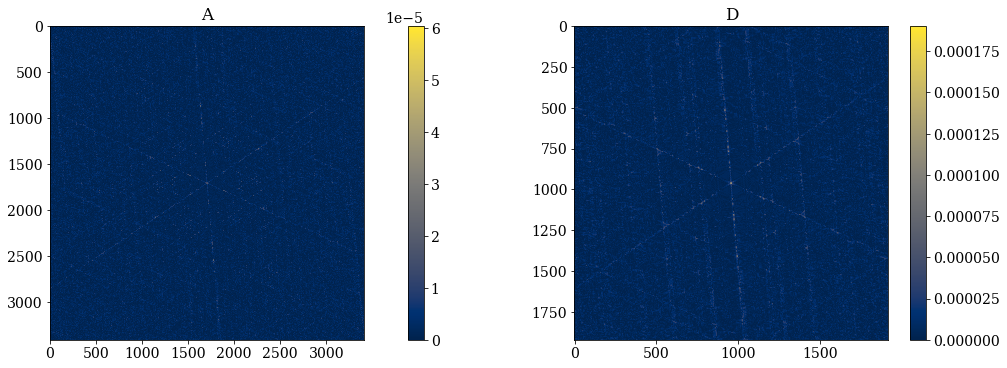

In [16]:
titles = ['A', 'D']
color = ['red', 'blue']
du = [40, 2]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5), constrained_layout=True)

for i, f in enumerate(files): 
    
    beam = get_beam(f, du[i], np.array([31.5]))
    im = axs[i].imshow(np.fft.fftshift(beam), cmap='cividis', interpolation='nearest')
    fig.colorbar(
        im,
        ax=axs[i],
        orientation="vertical",
        label="",
    )
    axs[i].set_title(titles[i])



## Part D

In [24]:
def get_uv_with_time(files, source_loc, freq = 1.4e9, norm = 1000, suptitle=None):
    
    titles = ['A', 'D']
    color = ['red', 'blue']
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), constrained_layout=True)
    du = [40, 2]

    for k, file in enumerate(files): 
        xyz, antpos = get_antenna_pos(file, return_antpos = True)

        nant = xyz[:,0].shape[0]
        nvis = nant * (nant - 1) // 2
        uv = np.zeros([nvis,3])
        icur=0
        for i in range(nant):
            for j in range(i+1,nant):
                uv[icur,:]=antpos[i,:]-antpos[j,:]
                icur=icur+1
        uv=np.vstack([uv,-uv]) / 3e8 * freq / norm # will be in kilowavelengths by default

        # Specify time range, convert to angles
        t_range=np.linspace(-4,4,64)
        theta_range=t_range*2*np.pi/24
        
        for theta in theta_range:
            rot_mat=np.zeros([3,3])
            rot_mat[0,0]=np.cos(theta)
            rot_mat[1,1]=np.cos(theta)
            rot_mat[2,2]=1.0
            rot_mat[0,1]=np.sin(theta)
            rot_mat[1,0]=-np.sin(theta)
            uv_rot=uv@rot_mat

            EW = np.array([0, 1, 0])
            NS = np.cross(source_loc, EW)
            proj_mat = np.vstack([EW, NS])
            uv_snap=uv_rot@proj_mat.T

            axs[k].plot(uv_snap[:,0],uv_snap[:,1],'.', color=color[k])

        
        axs[k].set_title(titles[k])
        axs[k].set_xlabel('kλ')
        axs[k].set_ylabel('kλ')
        axs[k].grid() 
        fig.suptitle(suptitle, fontweight='bold')        
        
    return fig
    

### Source #1: Overhead

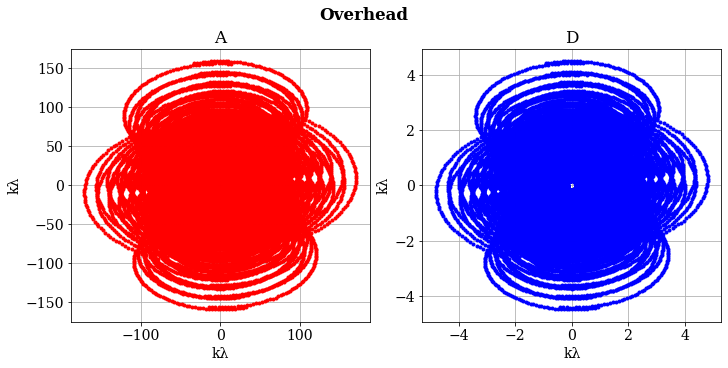

In [25]:
source_loc = np.array([np.cos(34.1*np.pi/180), 0, np.sin(34.1*np.pi/180)]) # located at Zenith
fig = get_uv_with_time(files, source_loc, freq = 1.4e9, norm = 1000, suptitle='Overhead')

### Source #2: At Equator

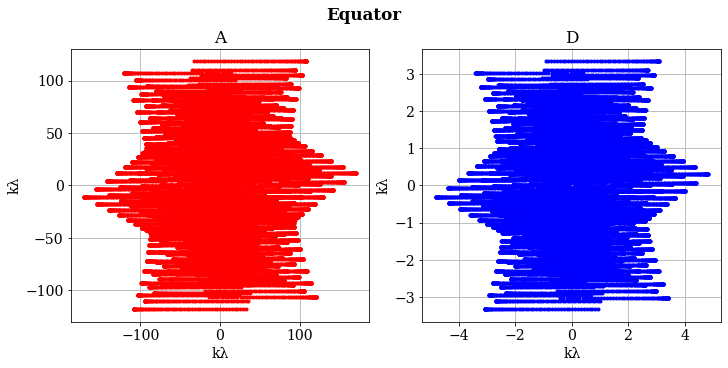

In [26]:
source_loc = np.array([np.cos(0), 0, np.sin(0)]) # located at equator
fig = get_uv_with_time(files, source_loc, freq = 1.4e9, norm = 1000, suptitle='Equator')

### Source #3: At North Pole

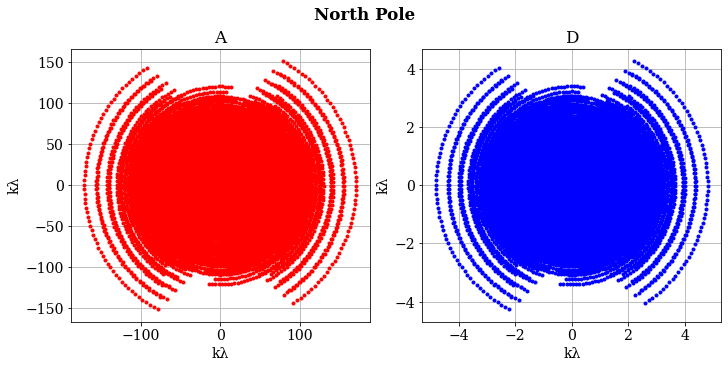

In [27]:
source_loc = np.array([np.cos(np.pi/2), 0, np.sin(np.pi/2)]) # located at North Pole
fig = get_uv_with_time(files, source_loc, freq = 1.4e9, norm = 1000, suptitle='North Pole')

## Part E

In [30]:
def get_beam_with_time(files, source_loc, freq = 1.4e9, norm = 100, suptitle=None):
    
    titles = ['A', 'D']
    color = ['red', 'blue']
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5), constrained_layout=True)
    du = [40, 2]

    for k, file in enumerate(files): 
        xyz, antpos = get_antenna_pos(file, return_antpos = True)

        nant = xyz[:,0].shape[0]
        nvis = nant * (nant - 1) // 2
        uv = np.zeros([nvis,3])
        icur=0
        for i in range(nant):
            for j in range(i+1,nant):
                uv[icur,:]=antpos[i,:]-antpos[j,:]
                icur=icur+1
        uv=np.vstack([uv,-uv]) / 3e8 * freq / norm 

        # Specify time range, convert to angles
        t_range=np.linspace(-4,4,64)
        theta_range=t_range*2*np.pi/24
        
        pad=4
        sz=int(np.max(np.abs(uv))/du[k])
        uv_mat=np.zeros([pad*2*sz,2*pad*sz])
        
        for theta in theta_range:
            rot_mat=np.zeros([3,3])
            rot_mat[0,0]=np.cos(theta)
            rot_mat[1,1]=np.cos(theta)
            rot_mat[2,2]=1.0
            rot_mat[0,1]=np.sin(theta)
            rot_mat[1,0]=-np.sin(theta)
            uv_rot=uv@rot_mat

            EW = np.array([0, 1, 0])
            NS = np.cross(source_loc, EW)
            proj_mat = np.vstack([EW, NS])
            uv_snap=uv_rot@proj_mat.T
            uv_int = np.asarray(uv_snap/du[k], dtype='int')
            
            for i in range(uv_snap.shape[0]):
                uv_mat[uv_int[i,0],uv_int[i,1]]=uv_mat[uv_int[i,0],uv_int[i,1]]+1


        beam = np.abs(np.fft.ifft2(uv_mat))
        x0=beam.shape[0]//2
        dx=99
        im = axs[k].imshow(np.fft.fftshift(beam), cmap='cividis', interpolation='nearest')
        fig.colorbar(
            im,
            ax=axs[k],
            orientation="vertical",
            label="",
        )
        axs[k].set_xlim([x0-dx,x0+dx])
        axs[k].set_ylim([x0-dx,x0+dx])
        axs[k].set_title(titles[k])
        fig.suptitle(suptitle, fontweight='bold')

    return fig
    

### Source #1: Overhead

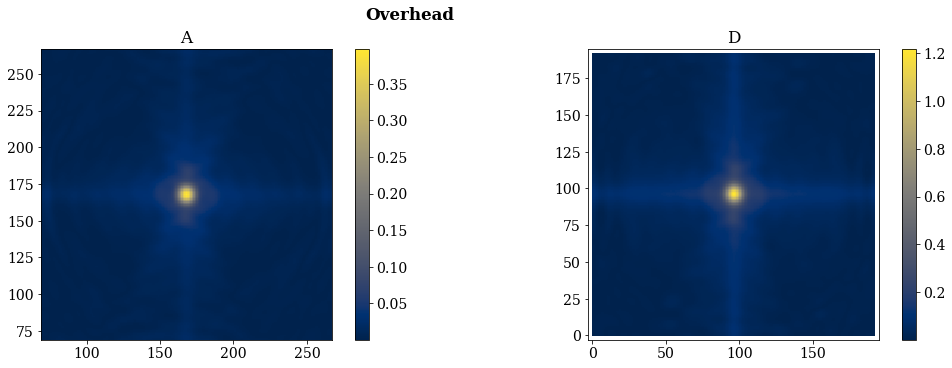

In [31]:
source_loc = np.array([np.cos(34.1*np.pi/180), 0, np.sin(34.1*np.pi/180)]) # located at Zenith
fig = get_beam_with_time(files, source_loc, freq = 1.4e9, suptitle='Overhead')

### Source #2: At Equator

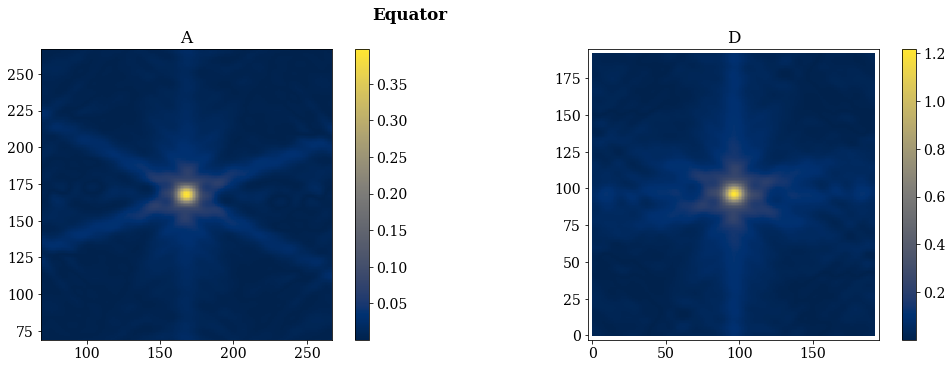

In [32]:
source_loc = np.array([np.cos(0), 0, np.sin(0)]) # located at equator
fig = get_beam_with_time(files, source_loc, freq = 1.4e9, suptitle='Equator')

### Source #3: At North Pole

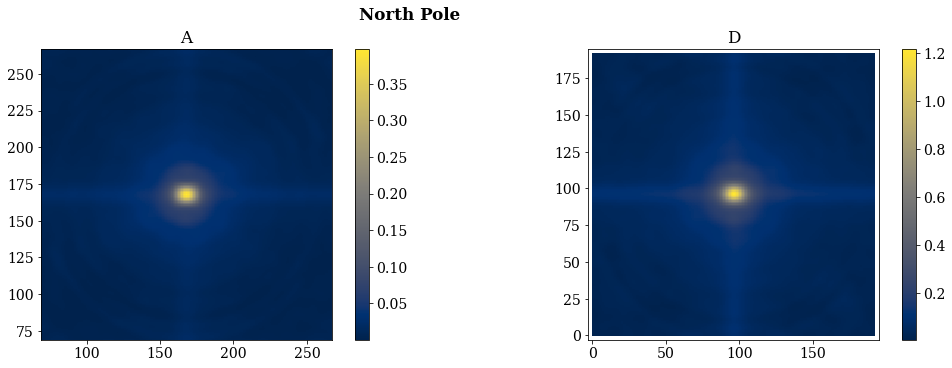

In [33]:
source_loc = np.array([np.cos(np.pi/2), 0, np.sin(np.pi/2)]) # located at North Pole
fig = get_beam_with_time(files, source_loc, freq = 1.4e9, suptitle='North Pole')

# Problem 2

## Part A

A single VLA dish has a diameter of 25 meters (after a quick google search). Assuming the beams of each individual telescope overlap (which to me seems to be a valid assumption), the total FOV will be roughly equal to the beam of one dish plus the north-south and east-west spread of the dishes. Seeing as the northernmost and southern most telescope are separated by roughly 30km, this corresponds to an angular separation of approximately
\begin{equation}
s = R_\text{Earth}\theta.
\end{equation}
With $s = 30 $ km in the NS direction, $R_\text{Earth} = 6378 $km , we get an angular separation of roughly 0.26 degrees. In the EW direction, $s = 36$ km yielding an angular separation of 0.32 deg.

At 1.4 GHz, a single dish has a beamwidth of $\theta = \lambda/D \sim 0.5$ deg. At 8 GHz, this decreases to $\theta = 0.09$ deg. Therefore, at 1.4 GHz, the VLA has an approximate FOV of 0.75 degrees NS and 0.82 deg EW. And at 8 GHz,  the VLA FOV is 0.35 deg NS and 0.41 deg EW. 